<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Cinzel&family=Rokkitt:ital@1&display=swap" rel="stylesheet">

<h1 style="text-align:center;font-family: 'Cinzel', serif;">Practical Lab 10</h1>
<h2 style="text-align:center;font-family: 'Cinzel', serif;">Waseem Raja Shaik</h2>
<h2 style="text-align:center;font-family: 'Cinzel', serif;">Student Id - 8894805</h2>

# Lab 10 - Fine-Tune VGG16 for Bird Classification

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand. 

This lab is the last one, so it is a bit more elaborated than the others. So make sure to take time to work through it.

A good starting point is to use the code in the notebook we went over in class - for fine-tuning VGG16. 

The goal of this lab is to achieve the best classification performance over three classes (species) of birds. This should be done by exploring data augmentation and fine-tuning of a pre-trained model (VGG16). Finally, explore and describe the results. 

If you are interested, you are encouraged to explore various training configurations, and see which one works better.

1. Obtain the Data
    1. Download the [BIRDS 525 SPECIES](https://www.kaggle.com/datasets/gpiosenka/100-bird-species?select=train) dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks. 
    2. Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (`ImageDataGenerator.flow_from_directory`). 
    3. For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.
2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)
3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes (2 points)
4. Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)


In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import pathlib
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import seaborn as sns


2023-08-06 19:55:39.549533: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-06 19:55:39.806701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_datagen = image.ImageDataGenerator(
    rotation_range=10,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.1,  # Set shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.05,  # Randomly zoom image 
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Points outside the boundaries of the input are filled according to the given mode
    preprocessing_function= keras.applications.vgg16.preprocess_input
)
test_datagen = image.ImageDataGenerator(
    preprocessing_function= keras.applications.vgg16.preprocess_input 
)

data_folder = pathlib.Path('../../data')
train_subdirs = os.listdir(data_folder / "train")
num_images_per_subdir = [(subdir, len(os.listdir(data_folder / "train" / subdir))) for subdir in train_subdirs]
sorted_subdirs = sorted(num_images_per_subdir, key=lambda x: x[1], reverse=True)

print('sorted dir based on number of images',sorted_subdirs)

selected_subdirs = [subdir for subdir, _ in sorted_subdirs[:3]]

print('Selected Directory',selected_subdirs)

train_generator = train_datagen.flow_from_directory(
    data_folder / "train",
    classes=selected_subdirs,
    target_size=(224, 224),
    batch_size=32)
validation_generator = test_datagen.flow_from_directory(
    data_folder / "valid",
    classes=selected_subdirs,
    target_size=(224, 224),
    batch_size=32)
test_generator = test_datagen.flow_from_directory(
    data_folder / "test",
    classes=selected_subdirs,
    target_size=(224, 224),
    batch_size=32)

sorted dir based on number of images [('RUFOUS TREPE', 263), ('HOUSE FINCH', 248), ('OVENBIRD', 233), ('D-ARNAUDS BARBET', 233), ('ASIAN GREEN BEE EATER', 220), ('SWINHOES PHEASANT', 216), ('WOOD DUCK', 214), ('CASPIAN TERN', 213), ('RED BILLED TROPICBIRD', 212), ('WOOD THRUSH', 211), ('FRILL BACK PIGEON', 209), ('MERLIN', 209), ('PYRRHULOXIA', 209), ('MILITARY MACAW', 208), ('ORNATE HAWK EAGLE', 208), ('OYSTER CATCHER', 207), ('LAUGHING GULL', 206), ('EASTERN YELLOW ROBIN', 205), ('JACOBIN PIGEON', 204), ('GREATER PRAIRIE CHICKEN', 203), ('DARK EYED JUNCO', 203), ('RED TAILED HAWK', 202), ('YELLOW BREASTED CHAT', 202), ('VIOLET BACKED STARLING', 201), ('VIOLET GREEN SWALLOW', 201), ('RED KNOT', 200), ('SORA', 200), ('PLUSH CRESTED JAY', 200), ('LIMPKIN', 200), ('GREY HEADED CHACHALACA', 199), ('CRIMSON SUNBIRD', 198), ('BLUE THROATED PIPING GUAN', 198), ('KNOB BILLED DUCK', 197), ('ROSE BREASTED COCKATOO', 197), ('CRESTED WOOD PARTRIDGE', 197), ('RED BEARDED BEE EATER', 197), ('CAMPO 

## Data augmentation train images

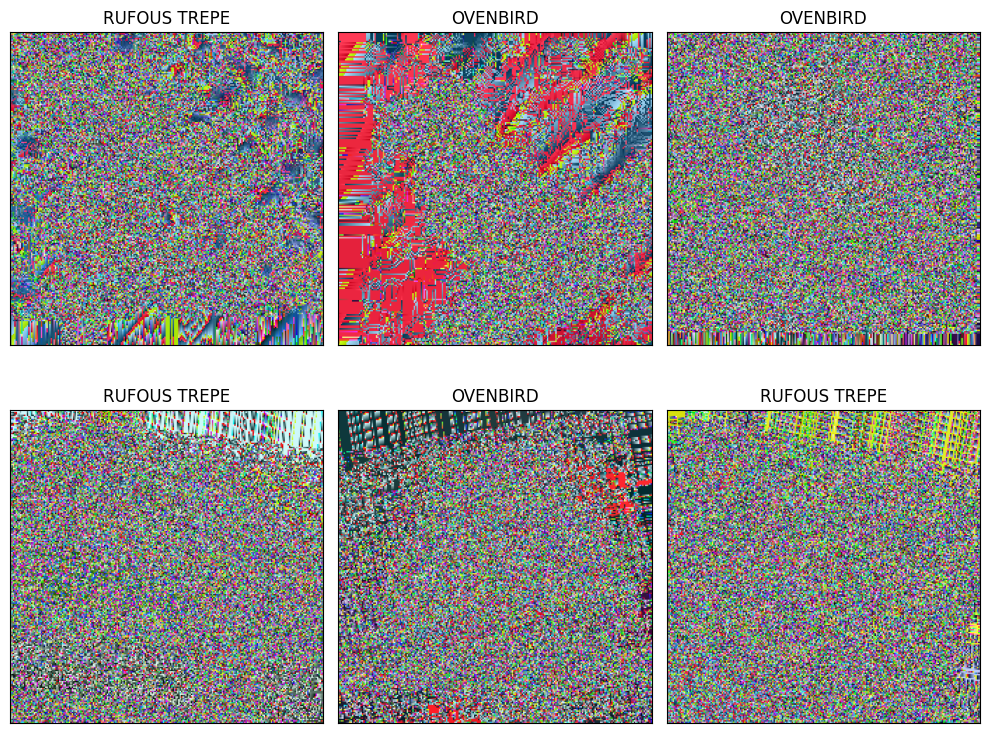

In [3]:
images_batch, labels_batch = next(train_generator)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    if i < 6:  
        ax.imshow(np.uint8(255 * images_batch[i]))
        ax.set_title(selected_subdirs[np.argmax(labels_batch[i])])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-4:]:
    layer.trainable = True

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(selected_subdirs), activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=outputs)


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/10


2023-08-06 19:55:44.105868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - ETA: 0s - loss: 2.3370 - accuracy: 0.5511

2023-08-06 19:57:52.116344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 129s 5s/step - loss: 2.3370 - accuracy: 0.5511 - val_loss: 0.4512 - val_accuracy: 0.7333
Epoch 2/10
24/24 [==============================] - 133s 6s/step - loss: 0.3088 - accuracy: 0.8831 - val_loss: 0.2518 - val_accuracy: 0.9333
Epoch 3/10
24/24 [==============================] - 134s 6s/step - loss: 0.1798 - accuracy: 0.9355 - val_loss: 0.2679 - val_accuracy: 0.9333
Epoch 4/10
24/24 [==============================] - 129s 5s/step - loss: 0.1716 - accuracy: 0.9503 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 128s 5s/step - loss: 0.0676 - accuracy: 0.9798 - val_loss: 5.8451e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 149s 6s/step - loss: 0.0649 - accuracy: 0.9839 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 182s 8s/step - loss: 0.0373 - accuracy: 0.9892 - val_loss: 8.6940e-06 - val_accuracy: 1.0000
Epoch 8/10
24/24

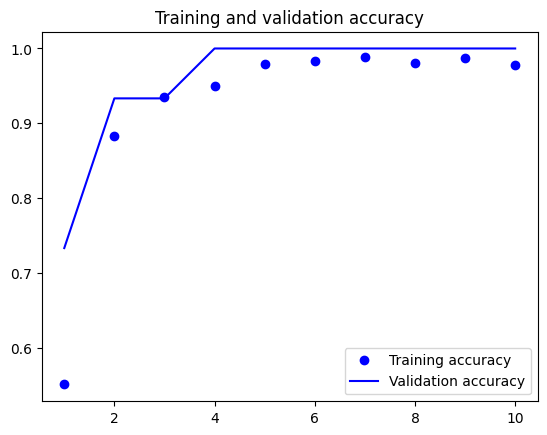

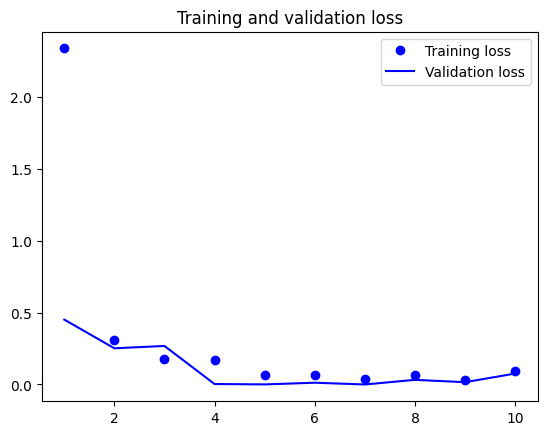

In [8]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

2023-08-06 20:21:39.219979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 1s/step - loss: 8.2651e-07 - accuracy: 1.0000
Test accuracy: 1.000


2023-08-06 20:21:40.348982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 1s/step


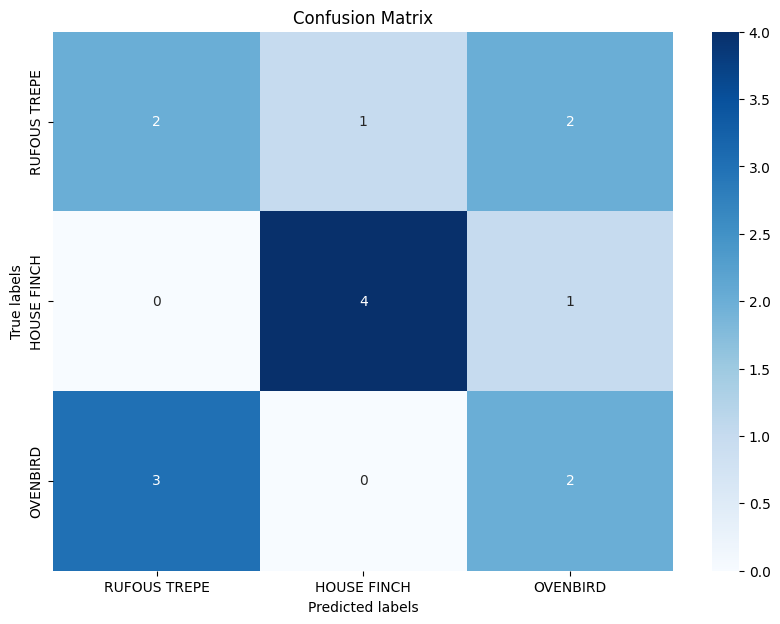

In [10]:
y_pred_probs = test_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=selected_subdirs, yticklabels=selected_subdirs)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [11]:
report = classification_report(y_true, y_pred, target_names=selected_subdirs)
print(report)

              precision    recall  f1-score   support

RUFOUS TREPE       0.40      0.40      0.40         5
 HOUSE FINCH       0.80      0.80      0.80         5
    OVENBIRD       0.40      0.40      0.40         5

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.53        15
weighted avg       0.53      0.53      0.53        15



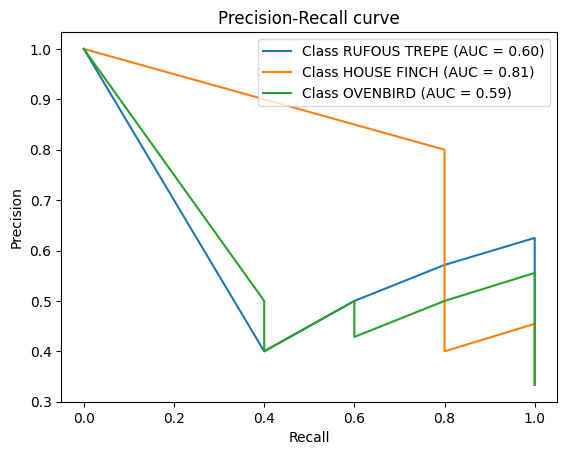

In [12]:
precision = dict()
recall = dict()
auc_score = dict()

for i in range(len(selected_subdirs)):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    auc_score[i] = auc(recall[i], precision[i])

for i in range(len(selected_subdirs)):
    plt.plot(recall[i], precision[i], label=f'Class {selected_subdirs[i]} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()


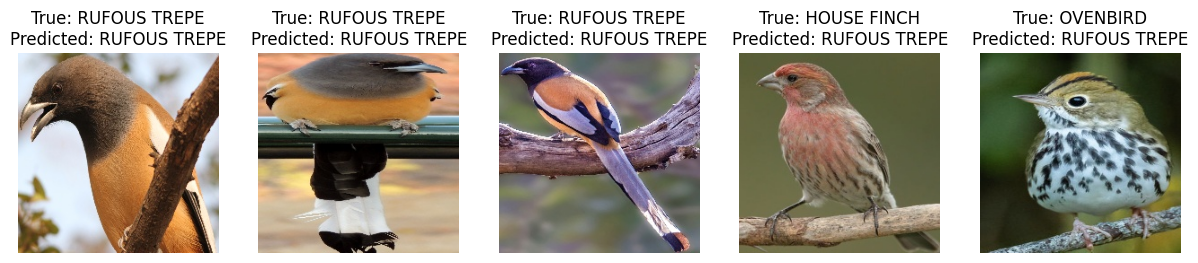

In [13]:
misclassified_indices = np.where(y_pred != y_true)[0]
num_examples_to_plot = min(5, len(misclassified_indices))

class_indices_to_names = {v: k for k, v in test_generator.class_indices.items()}

plt.figure(figsize=(15, 10))
for i in range(num_examples_to_plot):
    index = misclassified_indices[i]
    img = plt.imread(test_generator.filepaths[index])
    img_class = class_indices_to_names[y_true[index]]
    pred_class = class_indices_to_names[np.argmax(y_pred[index])]
    plt.subplot(1, num_examples_to_plot, i+1)
    plt.imshow(img)
    plt.title(f'True: {img_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()